## **Introduction**

<a id="1"></a>

Credit risk scoring methods are widely used for evaluating potential loan applications in both financial and banking institutions. These procedures allow banks to describe the likelihood of a default over a particular time horizon. 

Financial institutions deploy models that consider the credit history of the borrowers and the inputs from their own economic stress scenarios to measure credit risk. Keen awareness is needed to identify, measure, monitor and control credit risk, guarantee sufficient capital against these risks and adequate compensation for the risks incurred.

When an institution receives a loan application, a decision regarding the approval of the loan has to be made considering the applicant’s profile. There are two types of risks assoiciated with this decision:

- If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to an instituiton;

- If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial.

The data for this specific scenario is provided by LendingClub, a P2P lending company that provides loans without the need of any financial intermdediation and/or collateral. Investors are responsible for their own decision on lending. Even though the company has fitter borrowers who meet the minimum requirements, there is still a huge risk of non-repayment. This is the problem that this project works on by making the prediction of loan status for these applicants.

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve, cross_validate
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn import set_config
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.pipeline import  Pipeline
import warnings

**Additional configuration features for easier visualization**

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 0)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

**Checking Working Directory**

In [3]:
print("Current Working Directory:", os.getcwd()) 

Current Working Directory: C:\Users\raimu\Desktop\New folder


## **Importing Data and Data Description**

<a id="3"></a>

---

The dataset used in this research is available at: https://www.kaggle.com/datasets/wordsforthewise/lending-club

In [4]:
df_train = pd.read_csv("german_credit_data.xls", delimiter = ",")

In [5]:
df_train.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [6]:
df_train.dtypes.value_counts()

object    6
int64     5
dtype: int64

In [7]:
keep_list = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk']

drop_list = [col for col in df_train.columns if col not in keep_list]

print(drop_list)

['Unnamed: 0']


In [8]:
df_train.drop(labels=drop_list, axis=1, inplace=True)

## **Dataset Statistics and Initial Pre Processing**

---

<a id="4"></a>

Descriptive statistics for each of the numerical variable show the mean, standard deviation, minimum & maximum values and values which fall within 25/50/75% of the total data. 

In [9]:
df_train.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,Age,Job,Credit amount,Duration
count,1000.00000,1000.00000,1000.00000,1000.00000
mean,35.54600,1.90400,3271.25800,20.90300
std,11.37547,0.65361,2822.73688,12.05881
min,19.00000,0.00000,250.00000,4.00000
25%,27.00000,2.00000,1365.50000,12.00000
50%,33.00000,2.00000,2319.50000,18.00000
75%,42.00000,2.00000,3972.25000,24.00000
max,75.00000,3.00000,18424.00000,72.00000


In [10]:
print('This dataframe has {} rows and {} columns.'.format(df_train.shape[0], df_train.shape[1]))

This dataframe has 1000 rows and 10 columns.


**Missing Data**

In [11]:
def missing_data(df_train):
    total = df_train.isnull().sum()
    percent = (df_train.isnull().sum()/df_train.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in df_train.columns:
        dtype = str(df_train[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

missing_data(df_train)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
Total,0,0,0,0,183,394,0,0,0,0
Percent,0.0,0.0,0.0,0.0,18.3,39.4,0.0,0.0,0.0,0.0
Types,int64,object,int64,object,object,object,int64,int64,object,object


By dropping the rows with no values, the dataset will lose 577 instances which is more than half. That’s a significant loss of data. For this reason I opted to replace the Nan values with 'None' in order to avoid information loss.

In [12]:
df_train["Saving accounts"].fillna("none", inplace=True)
df_train["Checking account"].fillna("none", inplace=True)

### **Target Variable: "Risk"**
---

In machine learning, classification refers to a predictive modeling problem where a class label is predicted for a given example of input data. Classification is the process where computers group data together based on predetermined characteristics — supervised learning.

In this scenario, we are dealing with a **`binary classification`** problem. Class labels are often string values and must be mapped to numeric values before being provided to an algorithm for modeling. This is often referred to as label encoding.

To model credit risk our target variable can only take two values:
- If the applicant does not default = 0
- If the applicant defaults = 1

Lets start this analysis by looking at variable "Risk"

In [13]:
df_train['Risk'].value_counts(normalize=False)

good    700
bad     300
Name: Risk, dtype: int64

In [14]:
df_train.shape

(1000, 10)

By plotting this information it is evident that we are dealing with a clear **`class imbalance problem:`**

- Loans that are fully paid account for 70% of the data

- Loans that have charged off only account for 30%

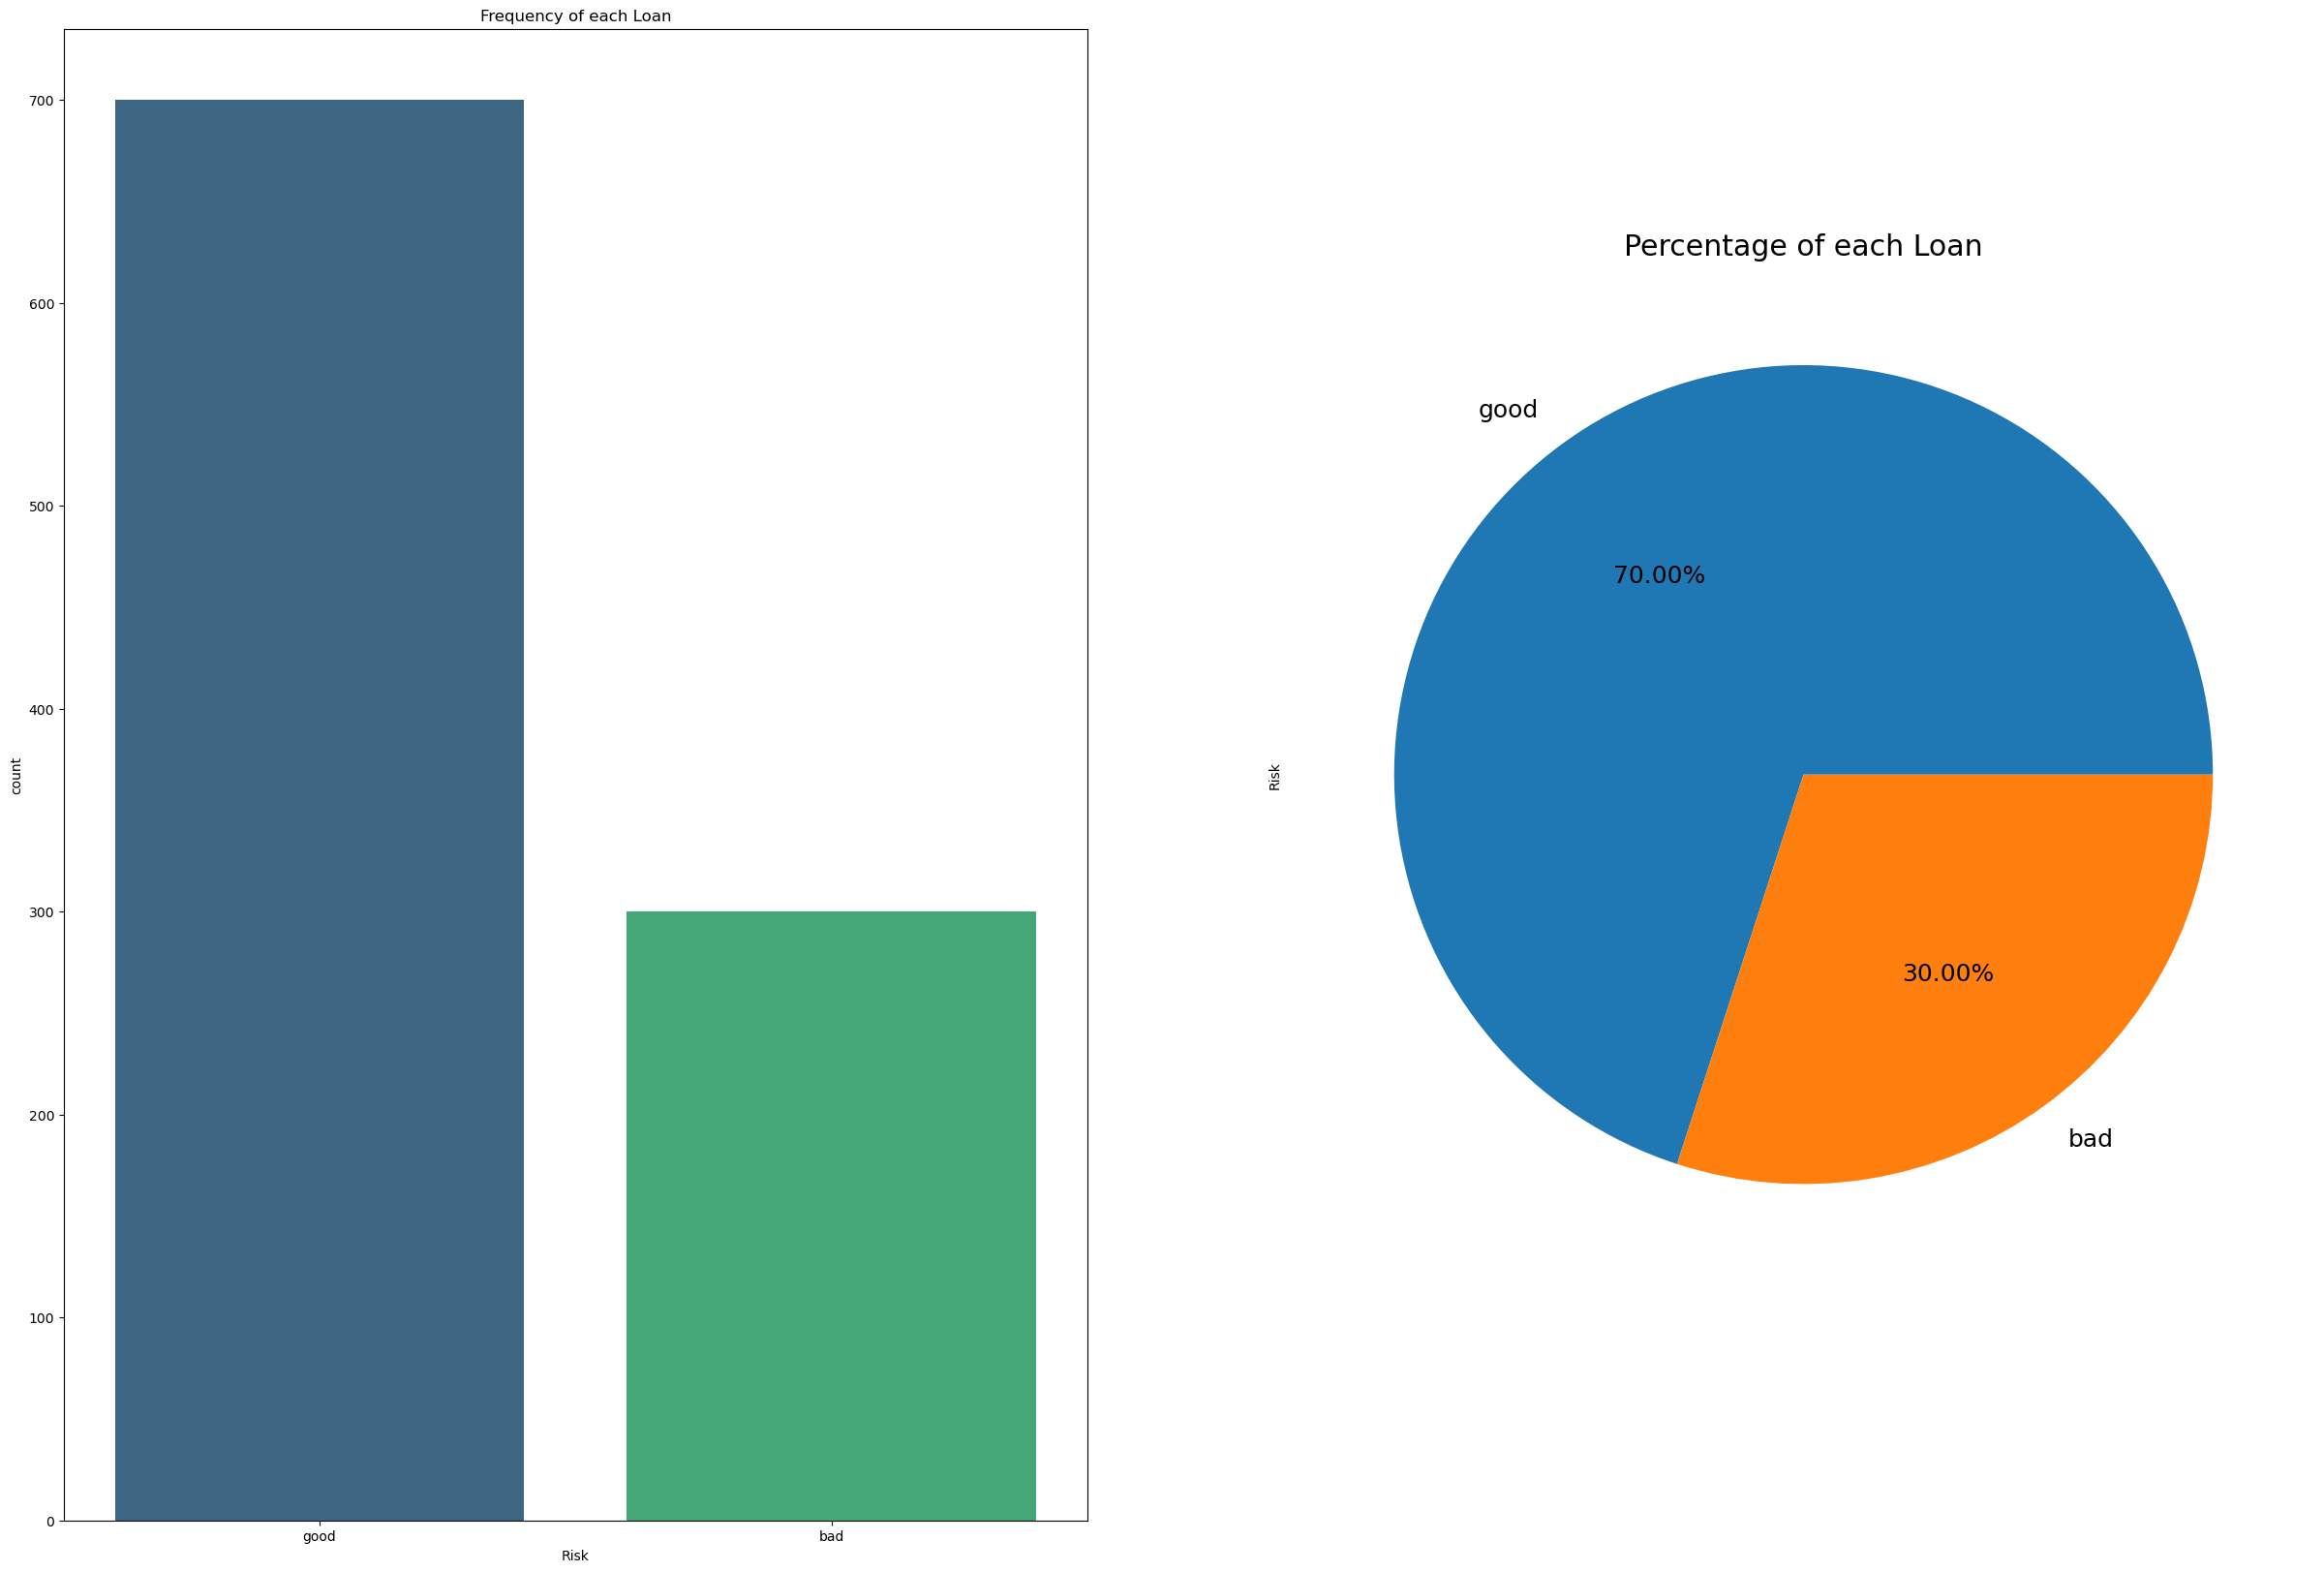

In [15]:
fig, axs = plt.subplots(1,2,figsize=(30,20))

sns.countplot(x='Risk',data=df_train,ax=axs[0], palette='viridis')

axs[0].set_title("Frequency of each Loan")

plt.rcParams['font.size'] = 18

df_train.Risk.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')

axs[1].set_title("Percentage of each Loan")

plt.grid(False)

plt.show()

## **Exploratory data analysis**

### **Variable: Sex**

---

In [16]:
df_train['Sex'].value_counts(normalize=False)

male      690
female    310
Name: Sex, dtype: int64

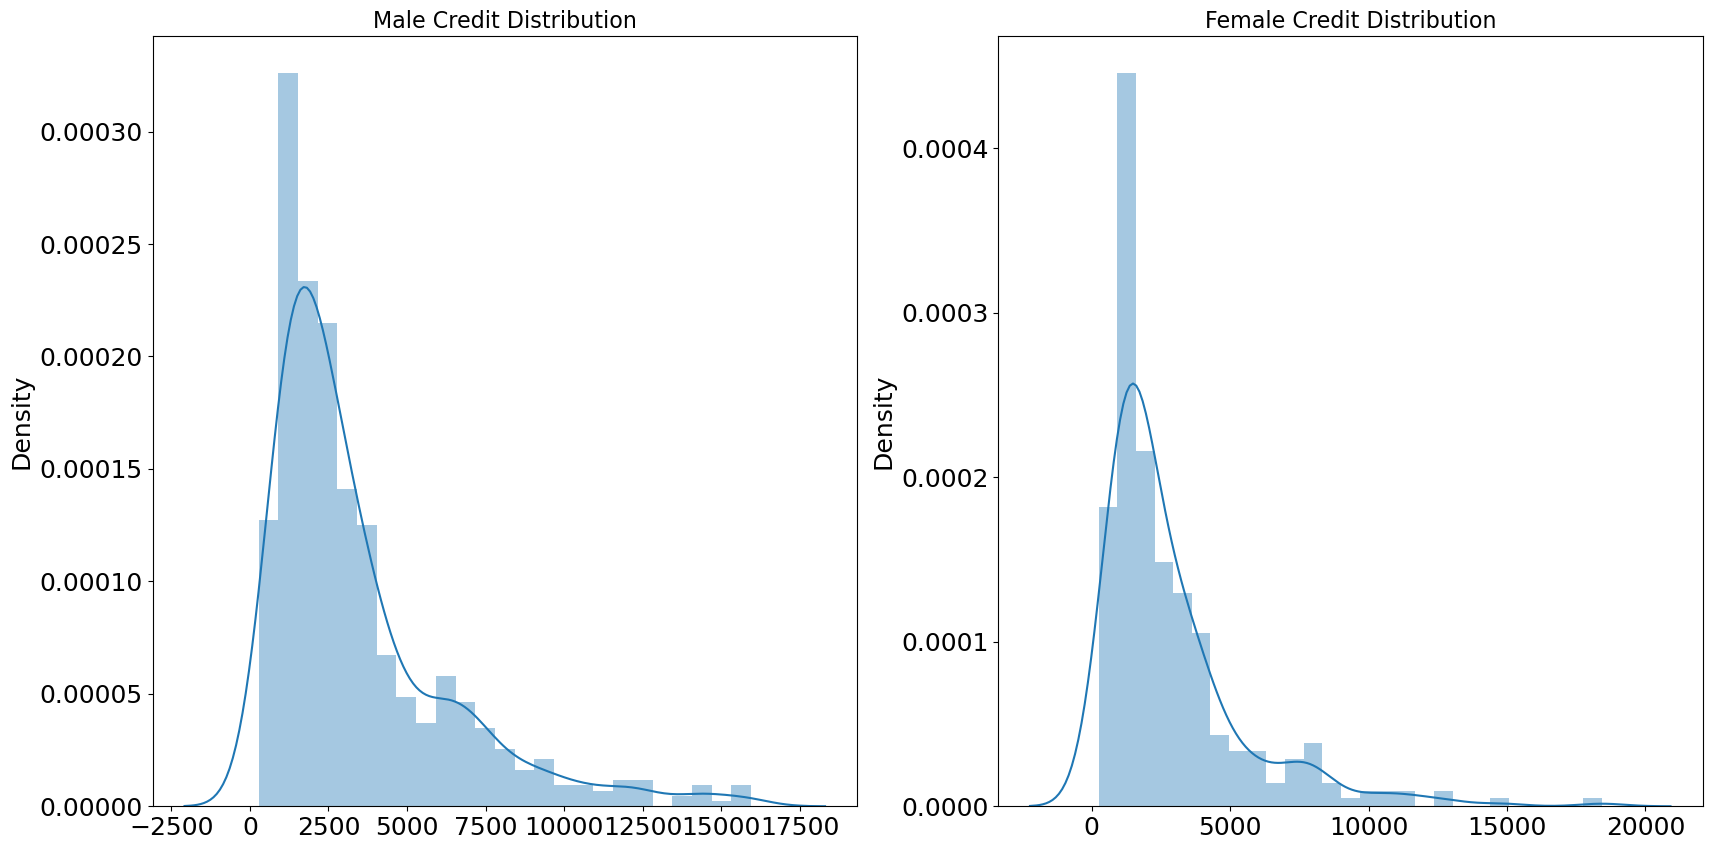

In [17]:
male_credit = df_train["Credit amount"].loc[df_train["Sex"] == "male"].values

female_credit = df_train["Credit amount"].loc[df_train["Sex"] == "female"].values

fig, ax = plt.subplots(1, 2, figsize=(20,10))

sns.distplot(male_credit, ax=ax[0])

ax[0].set_title("Male Credit Distribution", fontsize=16)

sns.distplot(female_credit, ax=ax[1])

ax[1].set_title("Female Credit Distribution", fontsize=16)

plt.show()

From the distribution by gender it is clear that the gender distributions is clearly skewed.

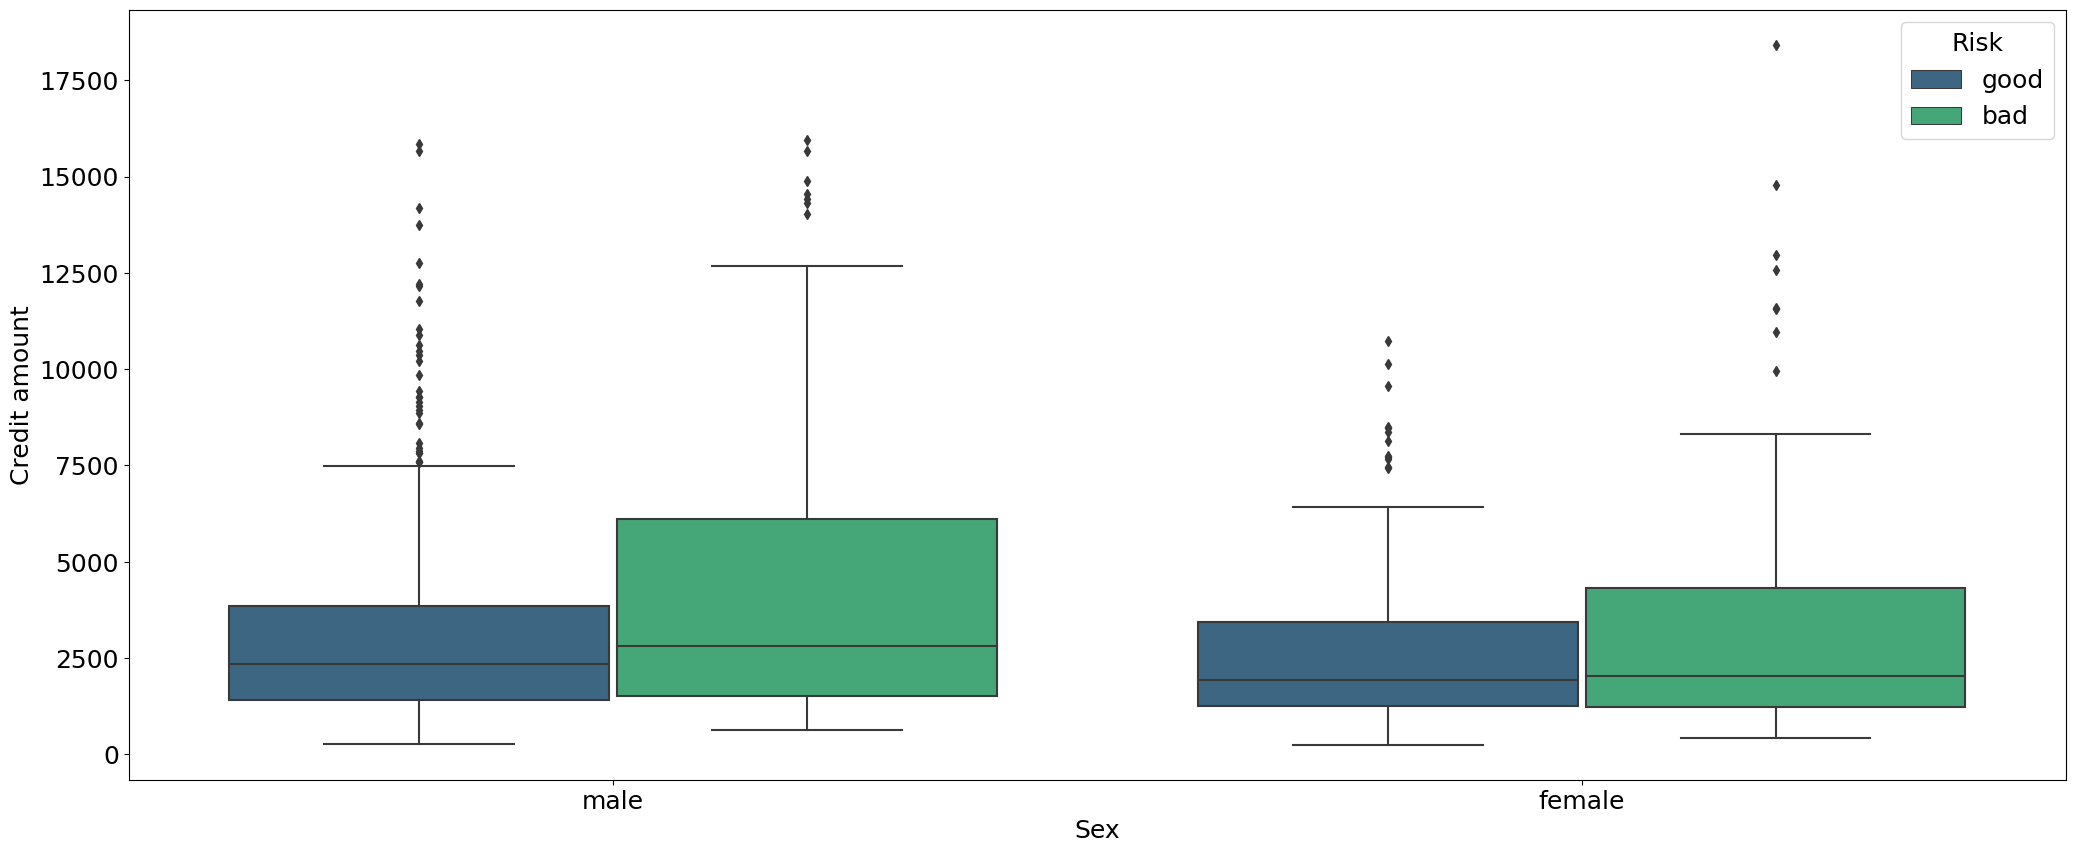

In [18]:
plt.figure(figsize=(25, 10))

sns.boxplot(data=df_train, x='Sex', y='Credit amount', palette='viridis', hue='Risk')

plt.show()

Some outliers clearly present in the data

**If we the Sex variable by age:**

We start this analysis by creating different age groups and plot the results

In [19]:
df_train['Age_Group'] = np.nan

lst = [df_train]

for col in lst:
    col.loc[(col['Age'] > 18) & (col['Age'] < 25), 'Age_Group'] = 'Young'
    col.loc[(col['Age'] >= 25) & (col['Age'] <= 40), 'Age_Group'] = 'Young Adults'
    col.loc[(col['Age'] > 40) & (col['Age'] <= 55), 'Age_Group'] = 'Senior'
    col.loc[col['Age'] > 55, 'Age_Group'] = 'Elder' 

In [20]:
keep_list = ['Age_Group', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk']

drop_list = [col for col in df_train.columns if col not in keep_list]

print(drop_list)

['Age']


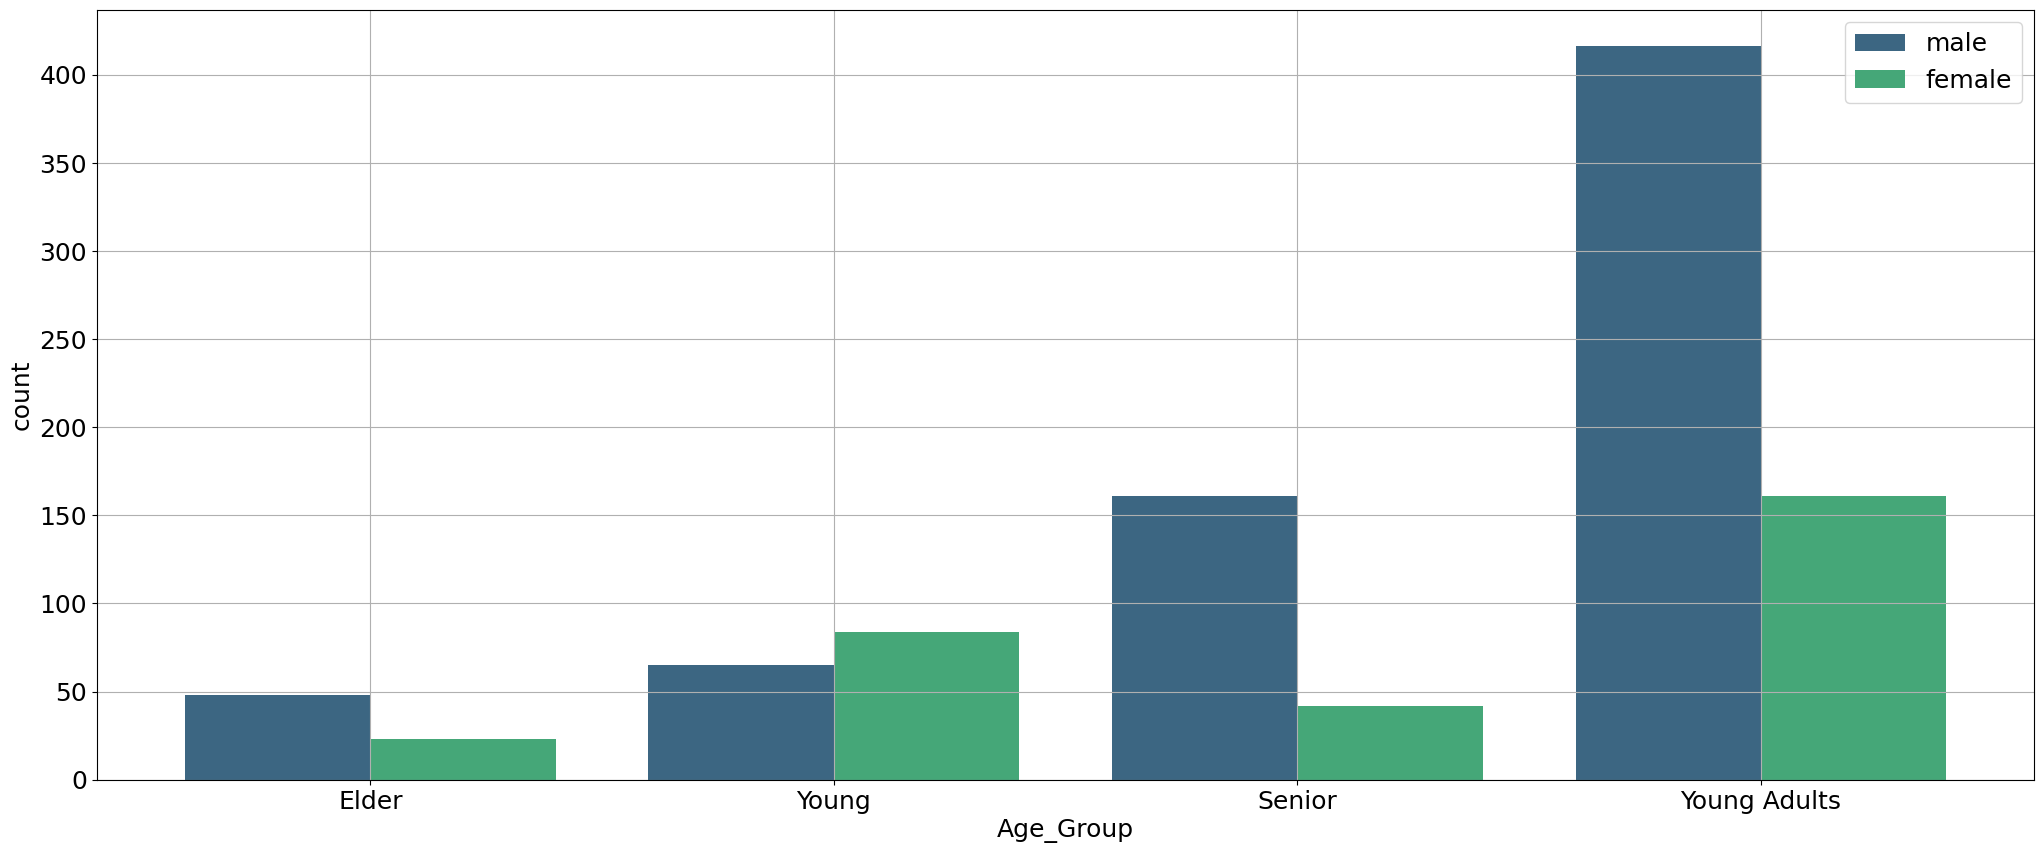

In [21]:
plt.figure(figsize=(25, 10))
sns.countplot(x='Age_Group', data=df_train, hue='Sex', palette='viridis')

plt.autoscale()
plt.grid(True)
plt.legend()
plt.show()

On every age group we have more males compared to females. In addition to this the younger crowd tends to ask for more loans compared to the older age groups. What about the purpose? How does it differentiate by gender?

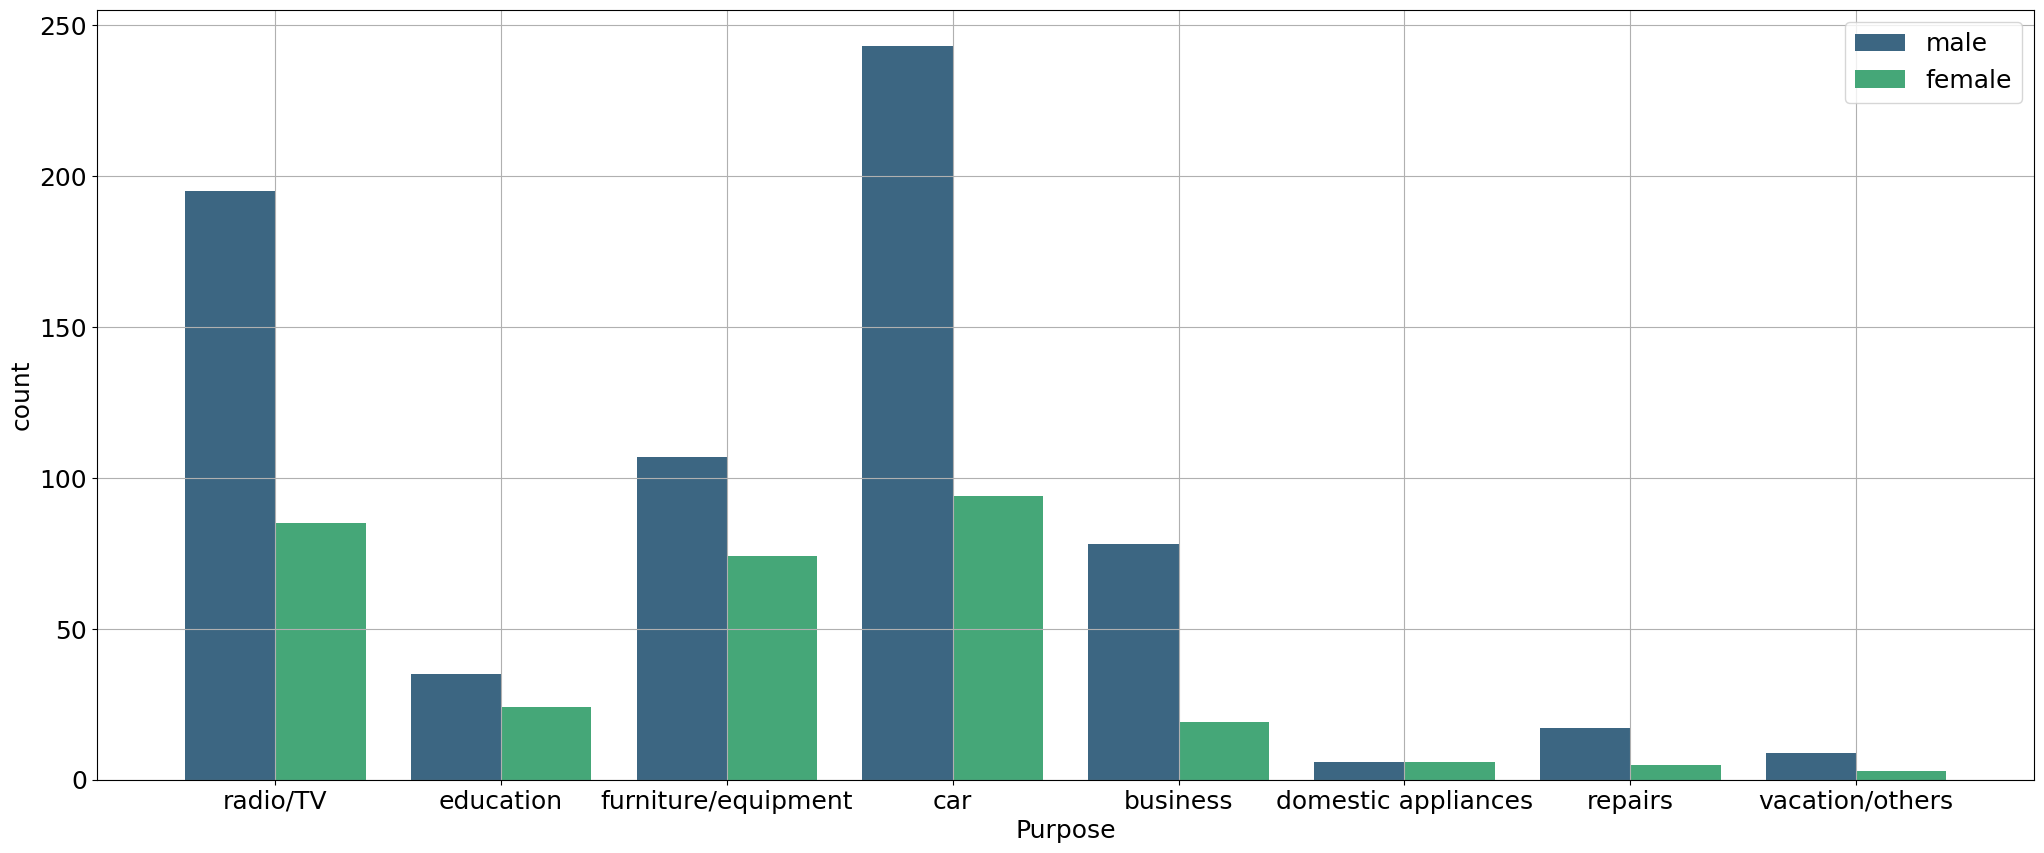

In [22]:
plt.figure(figsize=(25, 10))
sns.countplot(x='Purpose', data=df_train, hue='Sex', palette='viridis')

plt.autoscale()
plt.grid(True)
plt.legend()
plt.show()

What about gender unemployment? Hod does it look like in our data: 

In [23]:
number_of_jobs = pd.crosstab(df_train["Job"], df_train["Sex"]).apply(lambda x: x/x.sum() * 100)
number_of_jobs

Sex,female,male
Job,,
0,3.870968,1.449275
1,20.645161,19.710145
2,63.548387,62.753623
3,11.935484,16.086957


According to our data description: 

1) The variable 0 means unskilled and non-resident, 
2) The variable 1 means — unskilled and resident,
3) The variable 2 means — skilled,
4) The variable 3 means — highly skilled

By the looks of the percentage distribution it seem that females are slightly ahead in almost all categories besides highly skilled

To finish off this analysis how does the percentage of default look across genders?

In [24]:
df_train.groupby('Sex')['Risk'].value_counts(normalize=True)

Sex     Risk
female  good    0.648387
        bad     0.351613
male    good    0.723188
        bad     0.276812
Name: Risk, dtype: float64

Females present a higher percentage of default compared to males (35 % vs 28 %)

----------

### **Variable: Age_Group**

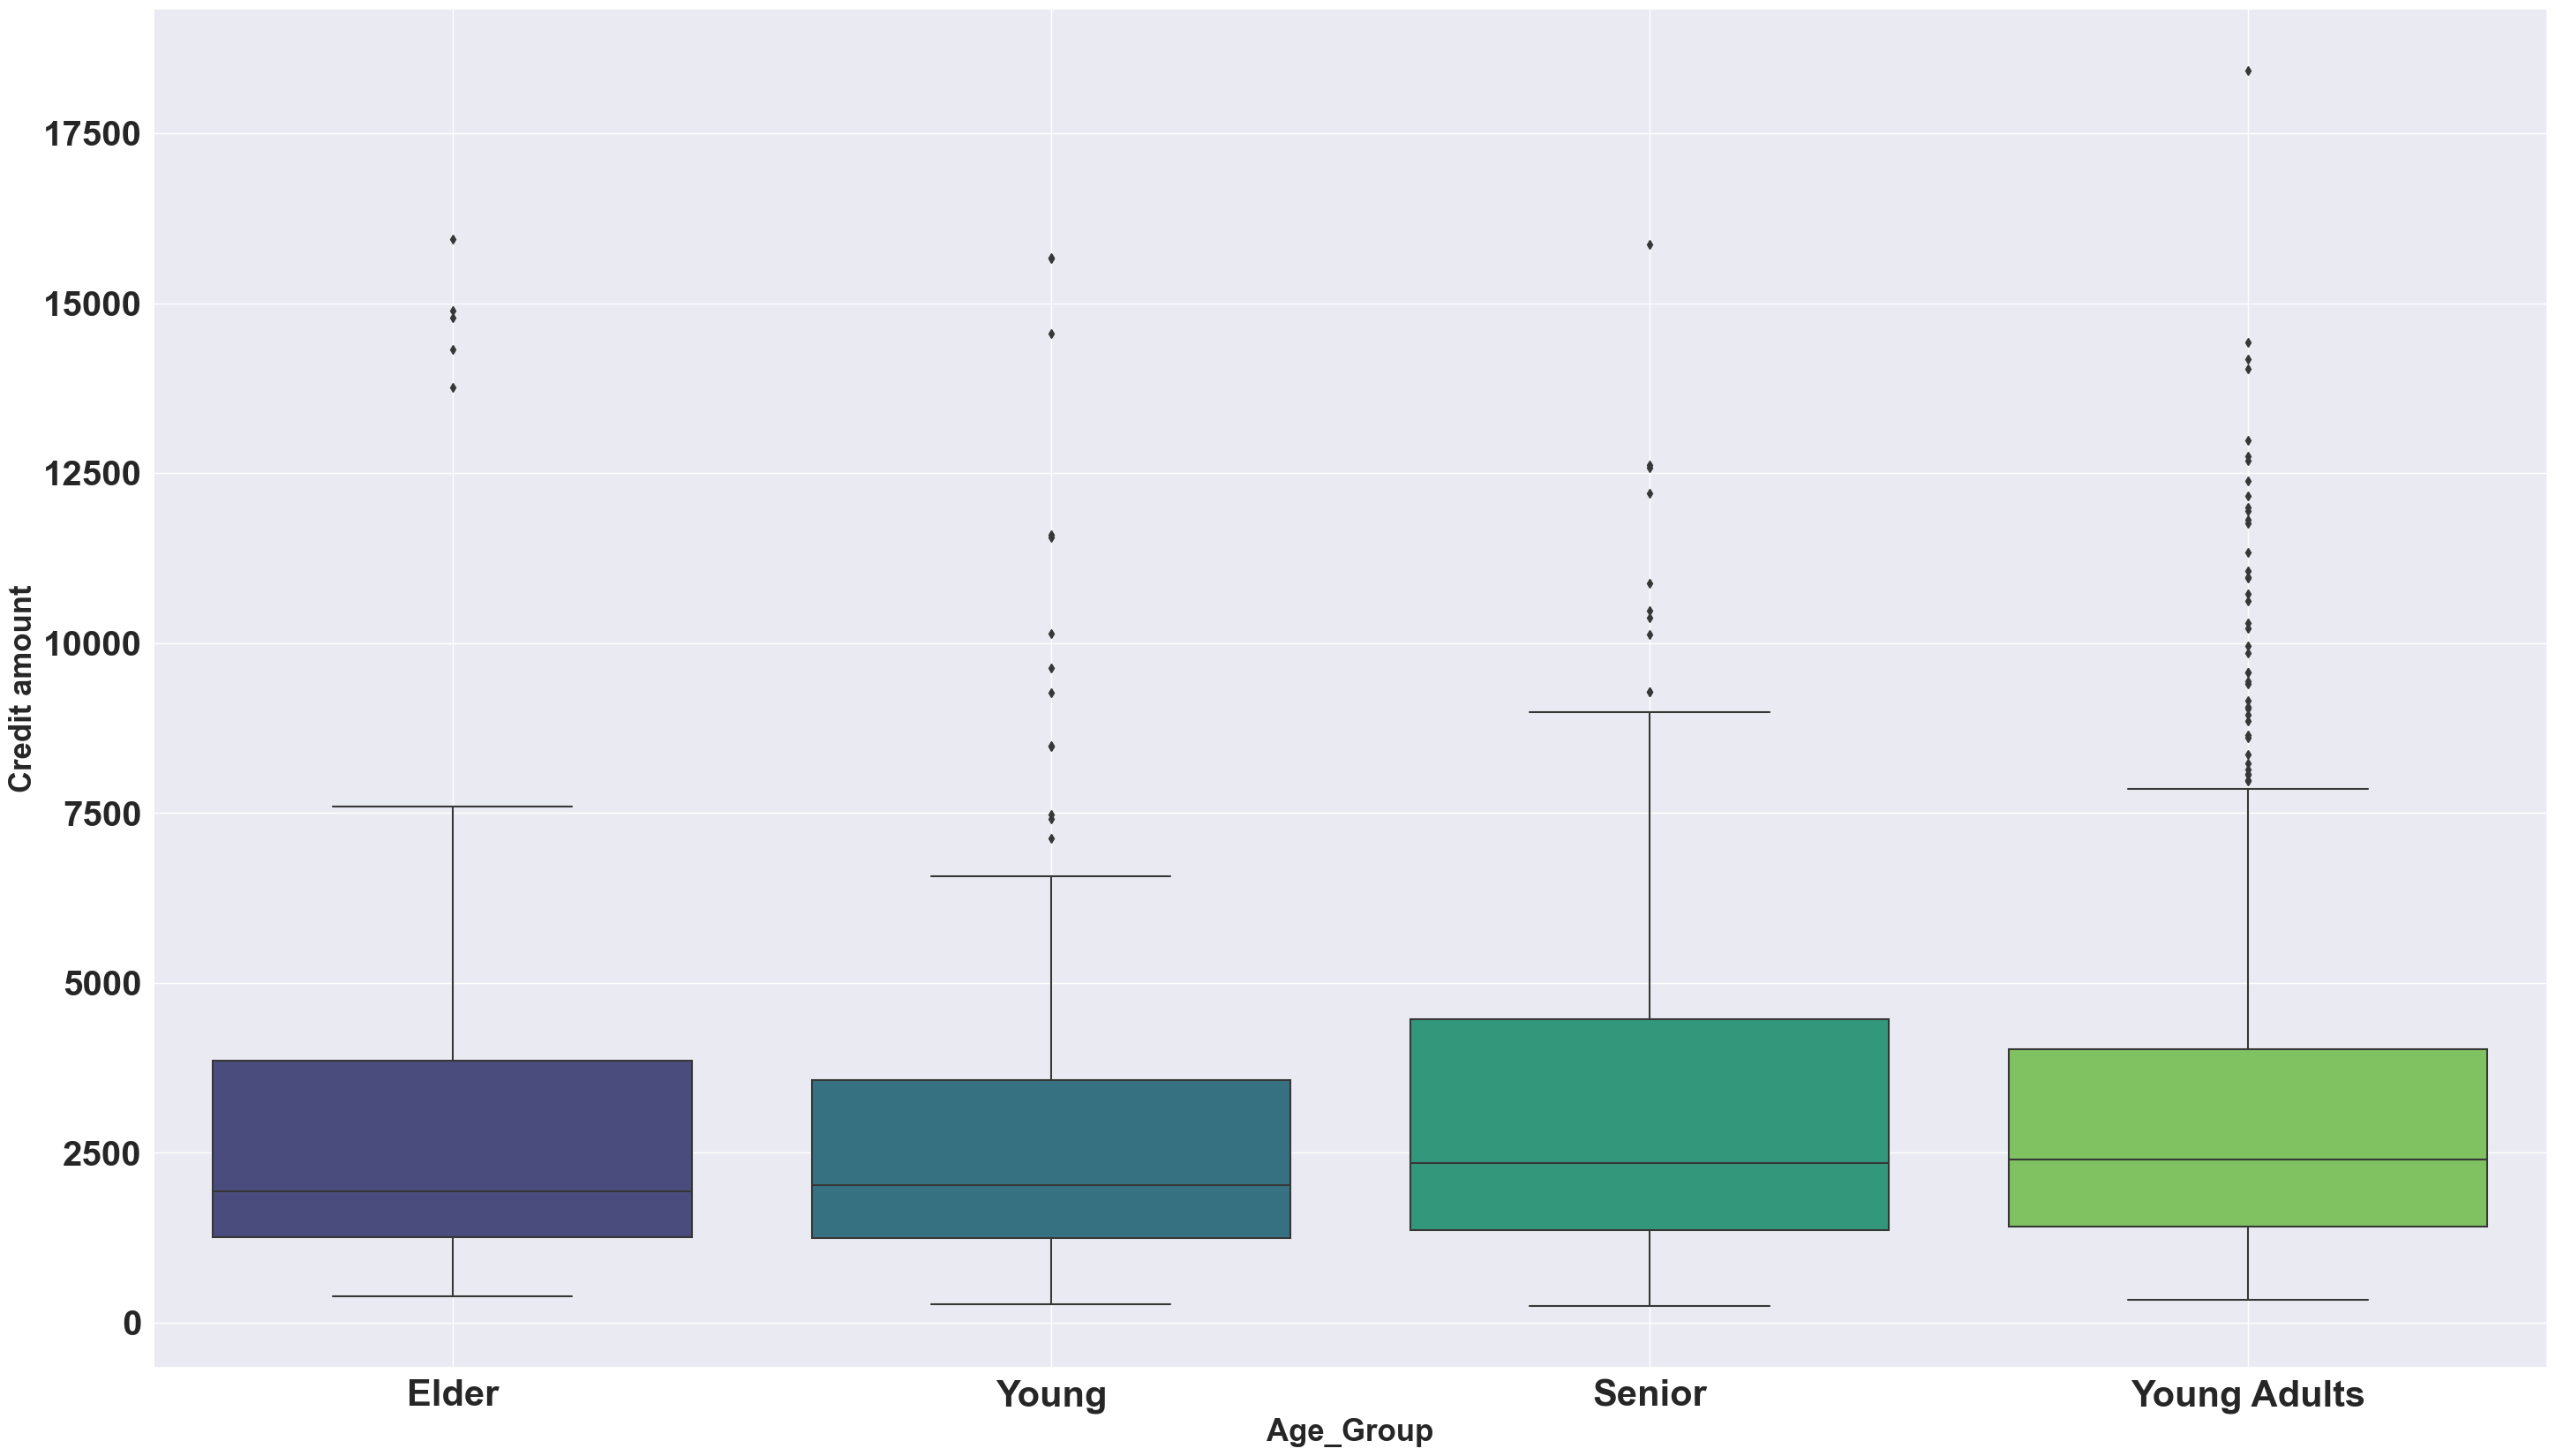

In [25]:
sns.set(rc={'figure.figsize':(35,20)})

sns.boxplot(x='Age_Group', y='Credit amount', data=df_train, palette='viridis')

plt.xticks(weight = 'bold', fontsize = 30)
plt.yticks(weight = 'bold', fontsize = 29)

plt.xlabel("Age_Group", fontsize=25, weight = 'bold')

plt.ylabel("Credit amount", fontsize=25, weight = 'bold')

plt.autoscale()

plt.grid(True)

plt.show()

Data distribution looks similiar with some outliers present. Highest loan request belongs to the Young Adults class

In [26]:
df_train.groupby('Age_Group')['Risk'].value_counts(normalize=True)

Age_Group     Risk
Elder         good    0.732394
              bad     0.267606
Senior        good    0.738916
              bad     0.261084
Young         good    0.590604
              bad     0.409396
Young Adults  good    0.710572
              bad     0.289428
Name: Risk, dtype: float64

As for % of default applicants like previously mentioned the younger crowd as a higher probability of default compared to the older crowd. this could be assoicaited with job stability. Lets code a simple cross table to see how the purpose is distributed by Age_Group

In [27]:
table1 = pd.crosstab(index=df_train['Age_Group'], columns=df_train['Purpose'])

table1

Purpose,business,car,domestic appliances,education,furniture/equipment,radio/TV,repairs,vacation/others
Age_Group,,,,,,,,
Elder,9,28,1,6,3,19,3,2
Senior,13,79,2,14,36,51,6,2
Young,7,39,4,7,42,45,5,0
Young Adults,68,191,5,32,100,165,8,8


Most fall in the car category followed by radio/TV

There is another interesting variable 'Checking account' which is measure of wealth let's see how does the wealth relate to age

In [28]:
df_train['Checking account'].value_counts(dropna=False)

none        394
little      274
moderate    269
rich        63 
Name: Checking account, dtype: int64

Missing values present in this variable. Let's ignore them for now

In [29]:
table1 = pd.crosstab(index=df_train['Age_Group'], columns=df_train['Checking account'])

table1

Checking account,little,moderate,none,rich
Age_Group,,,,
Elder,21,18,26,6
Senior,57,39,92,15
Young,57,46,38,8
Young Adults,139,166,238,34


The Younger Crowd present higher wealth compared to the more senior crowd.

--------------------

### **Variable: Housing**

In [30]:
df_train['Housing'].value_counts(dropna=False)

own     713
rent    179
free    108
Name: Housing, dtype: int64

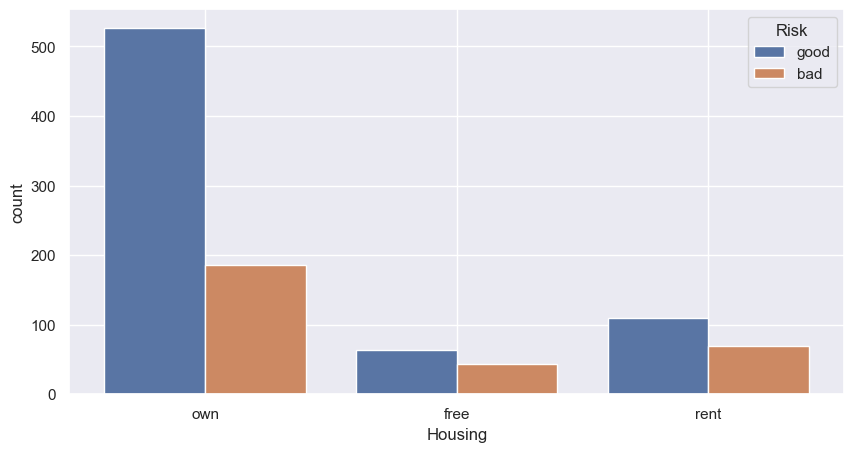

In [31]:
plt.figure(figsize=(10, 5))

sns.countplot(x='Housing', data=df_train, hue='Risk')

plt.autoscale()
plt.grid(True)

plt.show()

Most applicants own a house

Over half of the applicants who own a house classified as good

In [32]:
df_train.groupby('Housing')['Risk'].value_counts(normalize=True)

Housing  Risk
free     good    0.592593
         bad     0.407407
own      good    0.739130
         bad     0.260870
rent     good    0.608939
         bad     0.391061
Name: Risk, dtype: float64

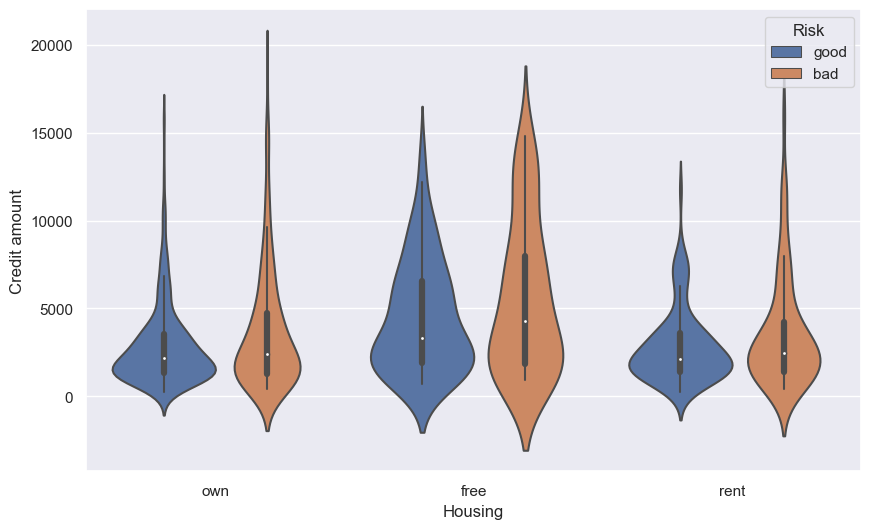

In [33]:
plt.figure(figsize=(10, 6))

sns.violinplot(data=df_train, x='Housing', y='Credit amount', hue='Risk')

plt.show()

The density curves from the violin plot suggest that there is a higher frequency of applicants with credit amounts below 5,000 $

-------

### **Checking and Saving Accounts Distribution**

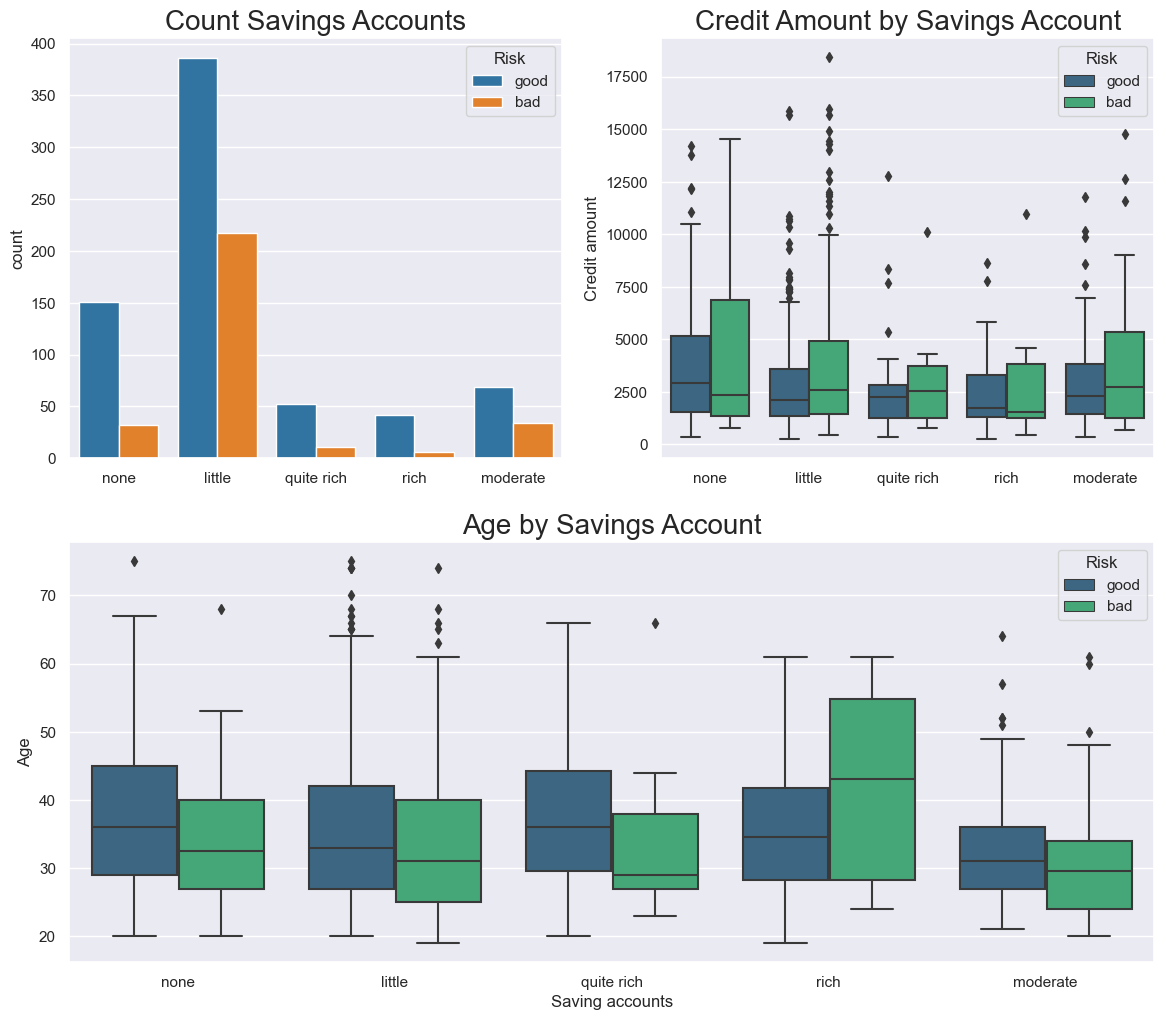

In [34]:
plt.figure(figsize=(14, 12))
plt.subplot(221)
ax1 = sns.countplot(data=df_train, x='Saving accounts', hue='Risk', palette='tab10')
ax1.set_title("Count Savings Accounts", fontsize=20)
ax1.set_xlabel("")

plt.subplot(222)
ax2 = sns.boxplot(data=df_train, x='Saving accounts', y='Credit amount', hue='Risk', palette='viridis')
ax2.set_title("Credit Amount by Savings Account", fontsize=20)
ax2.set_xlabel("")

plt.subplot(212)
ax3 = sns.boxplot(data=df_train, x='Saving accounts', y='Age', hue='Risk', palette='viridis')
ax3.set_title("Age by Savings Account", fontsize=20)

plt.show()

**Main conclusions:**
    
- The majority of the applicants are in the little category
- 50% of the applicants in the little category are between the age range of 25 and 45
- Applicants with moderate, quite rich, and rich savings accounts are more likely to be classified as good
- Applicants with little and no savings accounts with a credit amount loan that exceeds 5,000 $ are more likely to classify as bad

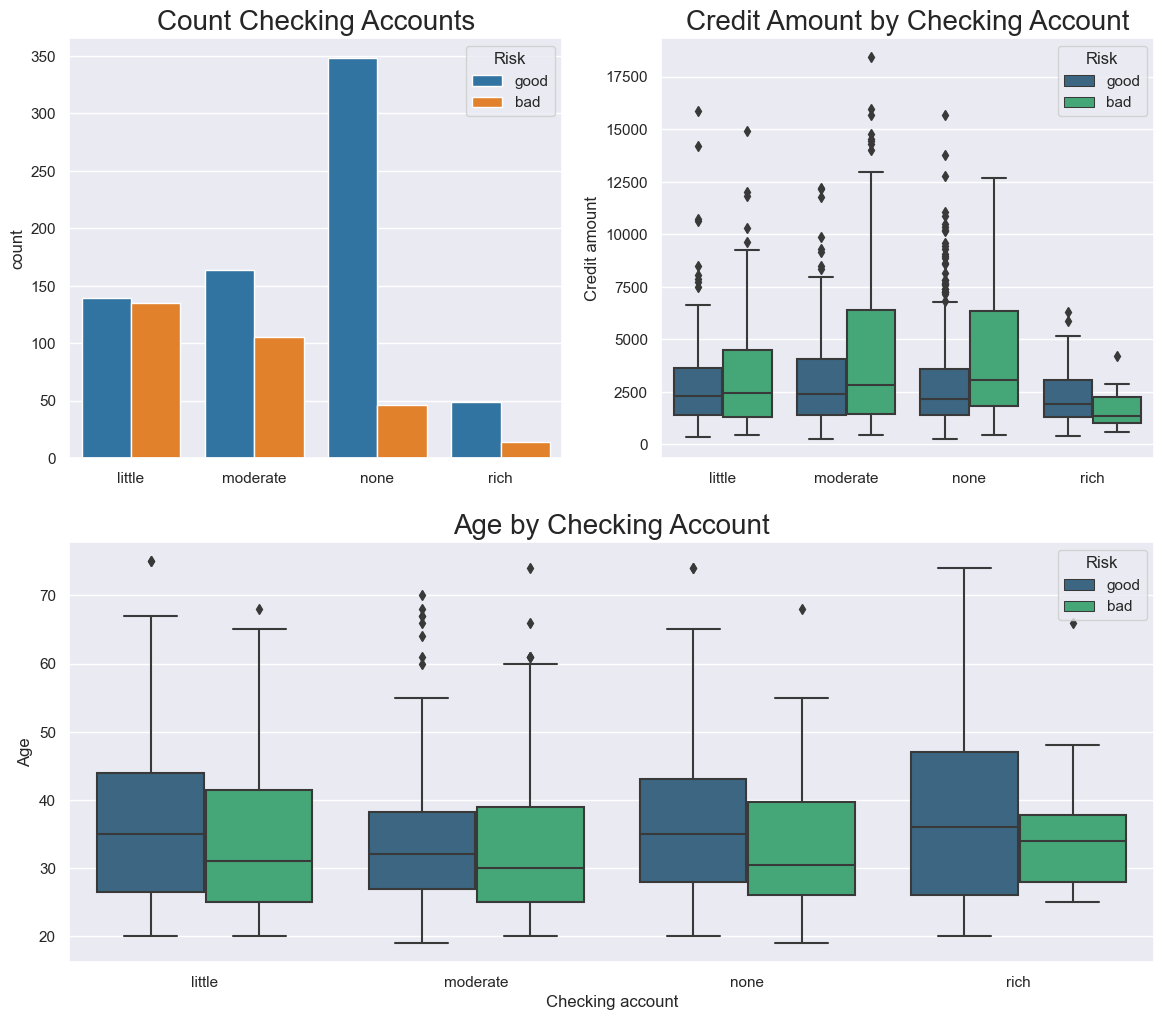

In [35]:
plt.figure(figsize=(14, 12))
plt.subplot(221)
ax1 = sns.countplot(data=df_train, x='Checking account', hue='Risk', palette='tab10')
ax1.set_title("Count Checking Accounts", fontsize=20)
ax1.set_xlabel("")

plt.subplot(222)
ax2 = sns.boxplot(data=df_train, x='Checking account', y='Credit amount', hue='Risk', palette='viridis')
ax2.set_title("Credit Amount by Checking Account", fontsize=20)
ax2.set_xlabel("")

plt.subplot(212)
ax3 = sns.boxplot(data=df_train, x='Checking account', y='Age', hue='Risk', palette='viridis')
ax3.set_title("Age by Checking Account", fontsize=20)

plt.show()

**Main conclusions:**

- Applicants with little or no saving accounts are more likely to apply for loans
- 50% of the applicants in the little category are between the age range of 25 and 45
- Applicants with moderate, and rich savings accounts are more likely to be classified as good
- Applicants with little and no savings accounts with a credit amount loan that exceeds 5,000 & are more likely to classify as bad

## **Pearson Correlation Matrix**

<a id="5.15"></a>

---
We use the Pearson correlation coefficient to examine the strength and direction of the linear relationship between two continuous variables.

The correlation coefficient can range in value from −1 to +1. The larger the absolute value of the coefficient, the stronger the relationship between the variables. For the Pearson correlation, an absolute value of 1 indicates a perfect linear relationship. A correlation close to 0 indicates no linear relationship between the variables. 

The sign of the coefficient indicates the direction of the relationship. If both variables tend to increase or decrease together, the coefficient is positive, and the line that represents the correlation slopes upward. If one variable tends to increase as the other decreases, the coefficient is negative, and the line that represents the correlation slopes downward.

* There seems to be a high correlation between Duration and Credit Amount but nothing to significant.

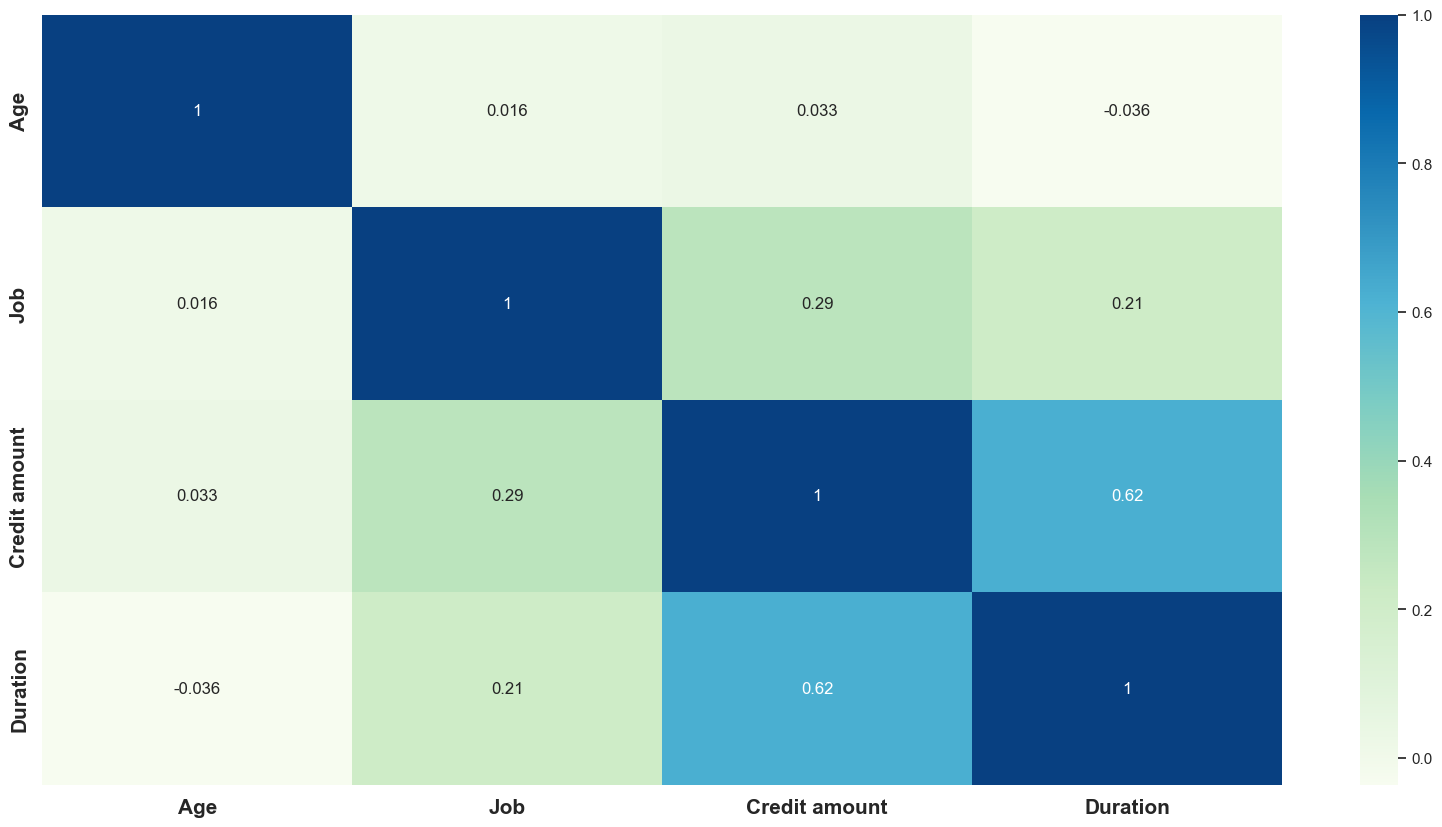

In [36]:
plt.figure(figsize=(20,10))

sns.heatmap(df_train.corr(method = 'pearson'), annot=True, cmap="GnBu")

plt.xticks(weight = 'bold', fontsize = 15)
plt.yticks(weight = 'bold', fontsize = 15)

#plt.title("Correlation Matrix", loc ="center", pad = 20, fontsize = 15, fontweight = "bold")

plt.show()

### **Encoding Variables**

<a id="5"></a>

---

**Encoding the target variable**

Many of our model variables are categorical and these need to be properly encoded for modeling. Bellow we convert our target variable and present the correlations with the remaining features. 

In [37]:
df_train['loans'] = df_train['Risk'].map({'bad': 1, 'good': 0})

df_train.drop(['Risk'],1, inplace=True)

We know create the target variable and copy of the dataset for modeling purposes

In [38]:
# Create a modeling dataset from the original dataset

X = df_train.copy(deep=True)

In [39]:
# Create the Target Variable

y = X['loans']

**Splitting the data into a train and test set**

For this research, the data was splitted in 80% for training and 20% for testing

In [40]:
# Split into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [41]:
# Remove the Target from the training

X_train = X_train.drop(['loans'],1)

X_test = X_test.drop(['loans'],1)

In [42]:
X_test.shape

(300, 10)

### **Building a Machine Learning Pipeline**


---

A machine learning pipeline is a way to automate the workflow enabling data to be transformed and correlated into a model that can then be analyzed to achieve outputs. This type of ML pipeline makes the process of inputting data into the ML model fully automated. For this particular notebook 5 different classification algorithmswere chosen and a pipeline was built for each one.

The Pipeline that we are going to build is going to do the following steps:

1) Encode categorical varaibles using Ordinal Encoding and One hot Encoding. Bellow we present our reasoning:

2) Standardize features using MaxAbsScaler

3) Apply chi square test to only use features that are relevant for the final model (due to the limited inforation in this dataset I opted to consider only five features)

4) Final Model deployment

**Categorical Columns**

In [43]:
categorical_variables = list(X_train.select_dtypes('object').columns)

print(f"Categorical columns are: {categorical_variables}")

Categorical columns are: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Age_Group']


**Numerical Columns**

In [44]:
numerical_variables = list(X_train.select_dtypes('number').columns)

print(f"Numerical columns are: {numerical_variables}")

Numerical columns are: ['Age', 'Job', 'Credit amount', 'Duration']


In [45]:
model1 = xgb.XGBClassifier(random_state = 123, objective='binary:logistic', scale_pos_weight = 3)
model2 = LogisticRegression(random_state = 123, class_weight ='balanced', penalty = 'l1', solver = 'liblinear')
model3 = DecisionTreeClassifier(random_state = 123, class_weight ='balanced',  min_samples_split = 100, max_depth = 10)
model4 = RandomForestClassifier(random_state = 123, class_weight ='balanced', min_samples_split = 100, max_depth = 10)
model5 = KNeighborsClassifier()

pipeline1 = Pipeline([('encoder', ColumnTransformer([('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore'), categorical_variables),])),
                     ('scaler', MaxAbsScaler()),
                     ('Select', SelectKBest(chi2, k=5)),
                     ('model', model1)])

pipeline2 = Pipeline([('encoder', ColumnTransformer([('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore'), categorical_variables),])),
                     ('scaler', MaxAbsScaler()),
                     ('Select', SelectKBest(chi2, k=5)),
                     ('model', model2)])

pipeline3 = Pipeline([('encoder', ColumnTransformer([('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore'), categorical_variables),])),
                     ('Select', SelectKBest(chi2, k=5)),
                     ('model', model3)])

pipeline4 = Pipeline([('encoder', ColumnTransformer([('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore'), categorical_variables),])),
                     ('Select', SelectKBest(chi2, k=5)),
                     ('model', model4)])

pipeline5 = Pipeline([('encoder', ColumnTransformer([('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore'), categorical_variables),])),
                     ('scaler', MaxAbsScaler()),
                     ('Select', SelectKBest(chi2, k=5)),
                     ('model', model5)])

In [46]:
pipeline1.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose', 'Age_Group'])])),
                ('scaler', MaxAbsScaler()),
                ('Select',
                 SelectKBest(k=5,
                             score_func=<function chi2 at 0x000001B809A788B0>)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callback...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               lear

In [47]:
pipeline2.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose', 'Age_Group'])])),
                ('scaler', MaxAbsScaler()),
                ('Select',
                 SelectKBest(k=5,
                             score_func=<function chi2 at 0x000001B809A788B0>)),
                ('model',
                 LogisticRegression(class_weight='balanced', penalty='l1',
                                    random_state=123, solver='liblinear'))])

In [48]:
pipeline3.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose', 'Age_Group'])])),
                ('Select',
                 SelectKBest(k=5,
                             score_func=<function chi2 at 0x000001B809A788B0>)),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_split=100,
                                        random_state=123))])

In [49]:
pipeline4.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose', 'Age_Group'])])),
                ('Select',
                 SelectKBest(k=5,
                             score_func=<function chi2 at 0x000001B809A788B0>)),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_split=100,
                                        random_state=123))])

In [50]:
pipeline5.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose', 'Age_Group'])])),
                ('scaler', MaxAbsScaler()),
                ('Select',
                 SelectKBest(k=5,
                             score_func=<function chi2 at 0x000001B809A788B0>)),
                ('model', KNeighborsClassifier())])

In [51]:
scoring = ['accuracy', 'precision', "recall", "f1"]

scores1 = cross_validate(pipeline1, X_train, y_train, scoring=scoring, return_train_score = True)
scores2 = cross_validate(pipeline2, X_train, y_train, scoring=scoring, return_train_score = True)
scores3 = cross_validate(pipeline3, X_train, y_train, scoring=scoring, return_train_score = True)
scores4 = cross_validate(pipeline4, X_train, y_train, scoring=scoring, return_train_score = True)
scores5 = cross_validate(pipeline5, X_train, y_train, scoring=scoring, return_train_score = True)

In [52]:
data = {'train_accuracy': [scores1["train_accuracy"].mean(), scores2["train_accuracy"].mean(), scores3["train_accuracy"].mean(), 
                           scores4["train_accuracy"].mean(), scores5["train_accuracy"].mean()],
        
        'test_accuracy': [scores1["test_accuracy"].mean(), scores2["test_accuracy"].mean(), scores3["test_accuracy"].mean(), 
                          scores4["test_accuracy"].mean(), scores5["test_accuracy"].mean()],
        
        'train_precision': [scores1["train_precision"].mean(), scores2["train_precision"].mean(), scores3["train_precision"].mean(), 
                            scores4["train_precision"].mean(), scores5["train_precision"].mean()],
    
        'test_precision': [scores1["test_precision"].mean(), scores2["test_precision"].mean(), scores3["test_precision"].mean(), 
                           scores4["test_precision"].mean(), scores5["test_precision"].mean()],
        
        'train_recall': [scores1["train_recall"].mean(), scores2["train_recall"].mean(), scores3["train_recall"].mean(), 
                         scores4["train_recall"].mean(), scores5["train_recall"].mean()],
        
        'test_recall': [scores1["test_recall"].mean(), scores2["test_recall"].mean(), scores3["test_recall"].mean(), 
                        scores4["test_recall"].mean(), scores5["test_recall"].mean()],
        
        'train_F1': [scores1["train_f1"].mean(), scores2["train_f1"].mean(), scores3["train_f1"].mean(), 
                     scores4["train_f1"].mean(), scores5["train_f1"].mean()],
        
        'test_F1': [scores1["test_f1"].mean(), scores2["test_f1"].mean(), scores3["test_f1"].mean(), 
                    scores4["test_f1"].mean(), scores5["test_f1"].mean()],
        
        'fit_time': [scores1["fit_time"].mean(), scores2["fit_time"].mean(), scores3["fit_time"].mean(),
                     scores4["fit_time"].mean(), scores5["fit_time"].mean()],
                        
        'score_time': [scores1["score_time"].mean(), scores2["score_time"].mean(), scores3["score_time"].mean(),
                       scores4["score_time"].mean(), scores5["score_time"].mean()]
       }



df = pd.DataFrame(data)

In [53]:
df

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_F1,test_F1,fit_time,score_time
0,0.643214,0.617143,0.449248,0.428356,0.830952,0.804762,0.582906,0.558364,0.055926,0.010932
1,0.638214,0.620000,0.444291,0.428135,0.813095,0.795238,0.574308,0.556365,0.011379,0.008495
2,0.643929,0.630000,0.447241,0.434999,0.791667,0.780952,0.571536,0.558494,0.013435,0.008465
3,0.647857,0.634286,0.450865,0.439654,0.792857,0.785714,0.574362,0.563111,0.310047,0.041569
4,0.691786,0.682857,0.493804,0.417183,0.269048,0.252381,0.308497,0.284521,0.017014,0.031634


By the looks of our dataframe it seems that the Logistic Regression performed better in comparision with the remainder classifiers. So I am going to use that model for hyperparamer tunning and final evaluation

**Applying Stratified K Fold Cross Validation**

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. When a specific value for k is chosen, it may be used in place of k in the reference to the model.

The general procedure of k fold cross validation goes as follows:

- Shuffle the dataset randomly.
- Pick a number of folds. For this research we considered K = 5 folds where 1 fold will be the test set and the remaining k-1 the training set
- Train the model on the training set. On each iteration of cross-validation, you must train a new model independently of the model trained on the previous iteration
- Validate the results on the test set by taking the average score

There are many types of cross-validation procedures but for this scenatio we are going to use Stratified K Fold Cross Validation  which is an extension of the cross-validation technique used for classification problems. 

It maintains the same class ratio throughout the K folds as the ratio in the original dataset. Ideal for imbalanced data

In [54]:
KF = StratifiedKFold(n_splits = 5)

### **Hyperparameter Tunning using GridSearchCV**

When designing a machine learning model, we will be presented with different choices as to how to define your model architecture. 

Often times, we don't immediately know what the optimal model architecture should be for a given model, and thus we'd like to be able to explore a range of possibilities. 

Parameters which define the model architecture are referred to as hyperparameters and thus this process of searching for the ideal model architecture is referred to as hyperparameter tuning.

This process usually goes as follows:
- Define a model
- Define the range of possible values for all hyperparameters (parameter grid)
- Define a method for sampling hyperparameter values
- Define an evaluative criteria to evaluate the model
- Define a cross-validation method

Parameter Grid

In [55]:
param_grid = {}
    
param_grid['model__C'] = [10**-1, 10**-2, 10**-3, 1]

Applying GridSearchCV

In [56]:
grid_sgdlogreg = GridSearchCV(pipeline2, param_grid,
                              scoring = 'f1', pre_dispatch = 3,
                              n_jobs = -1, cv = KF, verbose = 10, return_train_score = True, error_score = "raise")

search = grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [57]:
pd.concat([pd.DataFrame(search.cv_results_["params"]),pd.DataFrame(search.cv_results_["mean_test_score"], columns=["roc_auc"])],axis=1)

,model__C,roc_auc
0,0.100,0.554816
1,0.010,0.000000
2,0.001,0.000000
3,1.000,0.556365


Best score

In [58]:
search.best_score_

0.5563653832989035

Best Parameters

In [59]:
search.best_params_

{'model__C': 1}

Best Estimator and Fitting the model considering the results from GridSearchCV

In [60]:
clf = search.best_estimator_

# fitting the model for grid search 

clf.fit

<bound method Pipeline.fit of Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Housing',
                                                   'Saving accounts',
                                                   'Checking account',
                                                   'Purpose', 'Age_Group'])])),
                ('scaler', MaxAbsScaler()),
                ('Select',
                 SelectKBest(k=5,
                             score_func=<function chi2 at 0x000001B809A788B0>)),
                ('model',
                 LogisticRegression(C=1, class_weight='balanced', penalty='l1',
                                    random_state=123, solver='liblinear'))])>

**Predictions on both the training and test set**

In [61]:
grid_predictions_train = clf.predict(X_train)

grid_predictions_test =  clf.predict(X_test)

### **Performance Metrics**

<a id="7"></a>

---

Performance metrics are a part of every machine learning problem. Wether we are dealing with a classification or regression problem performance metrics are used to monitor and measure the performance of a model during training and testing. Since we are dealing with a classification problem the following performance metrics will be used:

- **Confusion Matrix:** Table layout which allows the visualization of the performance of an algorithm. A confusion matrix gives us four important measures:

    - True Positives (TP) – Default situations that are correctly classified as default.
    - True Negatives (TN) – Non-default situations that are correctly classified as non-default.
    - False Positives (FP) - Non-default applicants, but the model classified / predicted them as default. In statistics this is known as a Type I error. (a))
    - False Negatives (FN) – Default applicants, but the model classified / prediced them as non-default. In statistics this is known as a Type II error. (b))
    
    
a)  Type I Error (False Positive, FP): When the model predicts as defaulter but the applicant does not default (Affects profitability)

b)  Type II Error (False Negative, FN): Model predicts applicant as a non defaulter but he actually defaulted (affects losses and provisions)

False Positive errors affects profitability of the lender (the model predicts default but it was a good applicant) whereas the False Negative cases affects the risk side of the business (affecting losses and provisions) as the model predicits non default but the applicant defaulted.

- **Accuracy:** Accuracy simply refers to the number of correct predicitions divided by the total number of predictions.It is given by:

$$ Accuracy =  \frac{TP+TN}{TP+TN+FP+FN}$$

- **Precision Score**: Precision measures how accurately the model can capture default i.e out of the total predicted default cases, how many turned out to be default. 

$$ Precision =  \frac{TP}{TP+FP}$$

- **Recall/Sensitivity Score:** Recall or Sensitivity measures out of all the actual default cases; how many the model could predict correctly as default. 

     - It is known as the **True Positive Rate**

$$ Recall =  \frac{TP}{TP+FN}$$

- **Specificity:** It measures the proportion of correctly identified Non Defaults over the total of Non Default prediction made by the model.

    -  Also known as **True Negative Rate**


$$ Specificity =  \frac{TN}{TN+FP}$$

- **F1 Score:** : F1 Score represents a balance between precision and recall. Mathematically:

$$ F1  Score = 2 * \frac {(precision * recall)}{(precision + recall)}$$

- **ROC Curve and AUC Score:** ROC is a probability curve and AUC represent the degree or measure of separability. It tells how much the model is capable of distinguishing between classes.

A critical and somewhat overlooked part of classification is deciding whether to prioritize precision or recall. This is more of a business question than a data science one and requires that we have a clear idea of our objective as well as how the costs of false positives compare to those of false negatives.

**Defining a funtion for the performance metrics**

In [62]:
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
    
  measures_list = ['ACCURACY','PRECISION', 'RECALL', "F1 SCORE"]

  train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain),
                metricsObj.f1_score(yTrain, yPredTrain)]
    
  test_results = [metricsObj.accuracy_score(yTest, yPredTest),
                metricsObj.precision_score(yTest, yPredTest),
                metricsObj.recall_score(yTest, yPredTest),
                metricsObj.f1_score(yTest, yPredTest)]

  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
    
  return(resultsDF)

**Defining a funtion for the confusion matrix**

In [63]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
 

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    bottom, top = ax.get_ylim() # These two lines were added due to bug on current Seaborn version
    ax.set_ylim(bottom + 0.5, top - 0.5) #

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

**Plot Confusion Matrix**

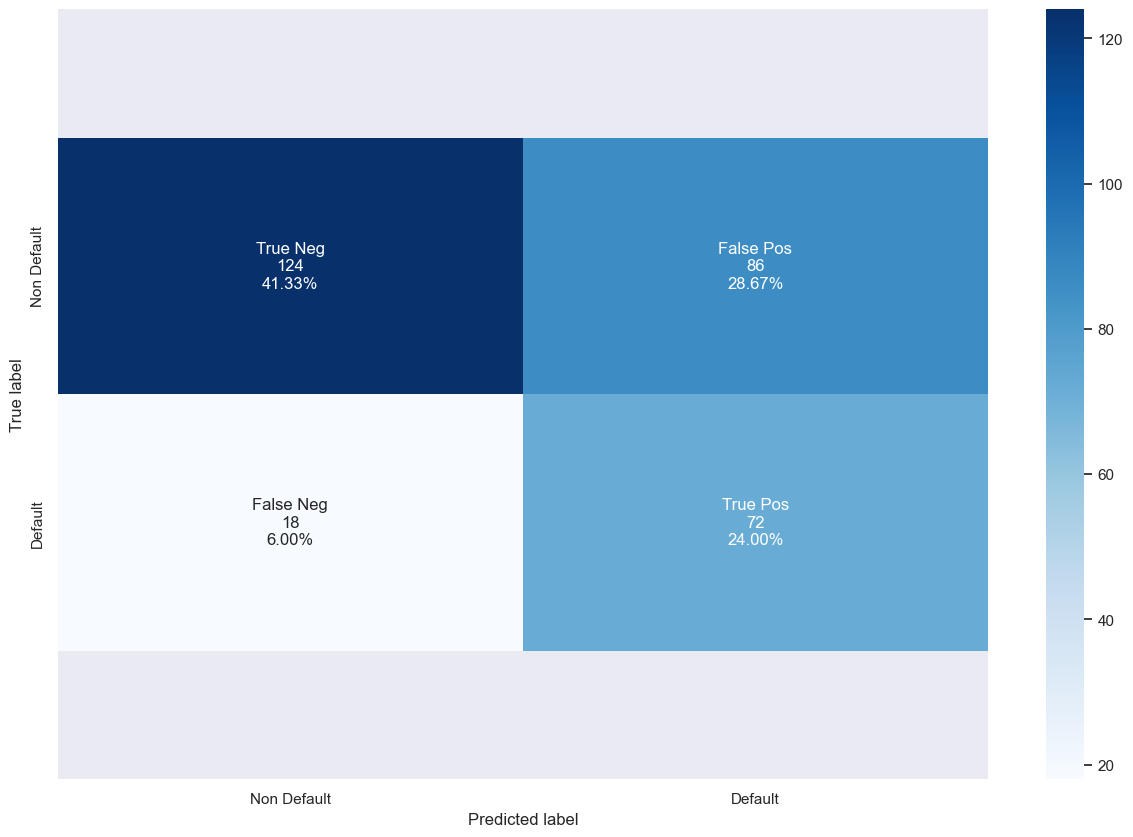

In [64]:
cf = metrics.confusion_matrix(y_test, grid_predictions_test)

labels = ['True Neg','False Pos','False Neg','True Pos']

categories = ['Non Default', 'Default']

make_confusion_matrix(cf, group_names=labels,categories=categories, cmap='Blues', figsize = (15,10))

**Dataframe with results for the Positive Class (Predict Default)**

This Dataframe compiles the information of the positive class for the train and test set using the results of both classification reports

In [65]:
resultsDF = performanceMetricsDF(metrics, y_train, grid_predictions_train, y_test, grid_predictions_test)

resultsDF

,Measure,Train,Test
0,ACCURACY,0.644286,0.653333
1,PRECISION,0.448819,0.455696
2,RECALL,0.814286,0.800000
3,F1 SCORE,0.578680,0.580645


From the looks f the final results it seems ou model performed rather well using the Logistic Regression. By tempering with the class_weight attribute we were able to avoid any sampling techniques. In addition to this, no sampling techniques were used.

**Function that computes the ROC curve**

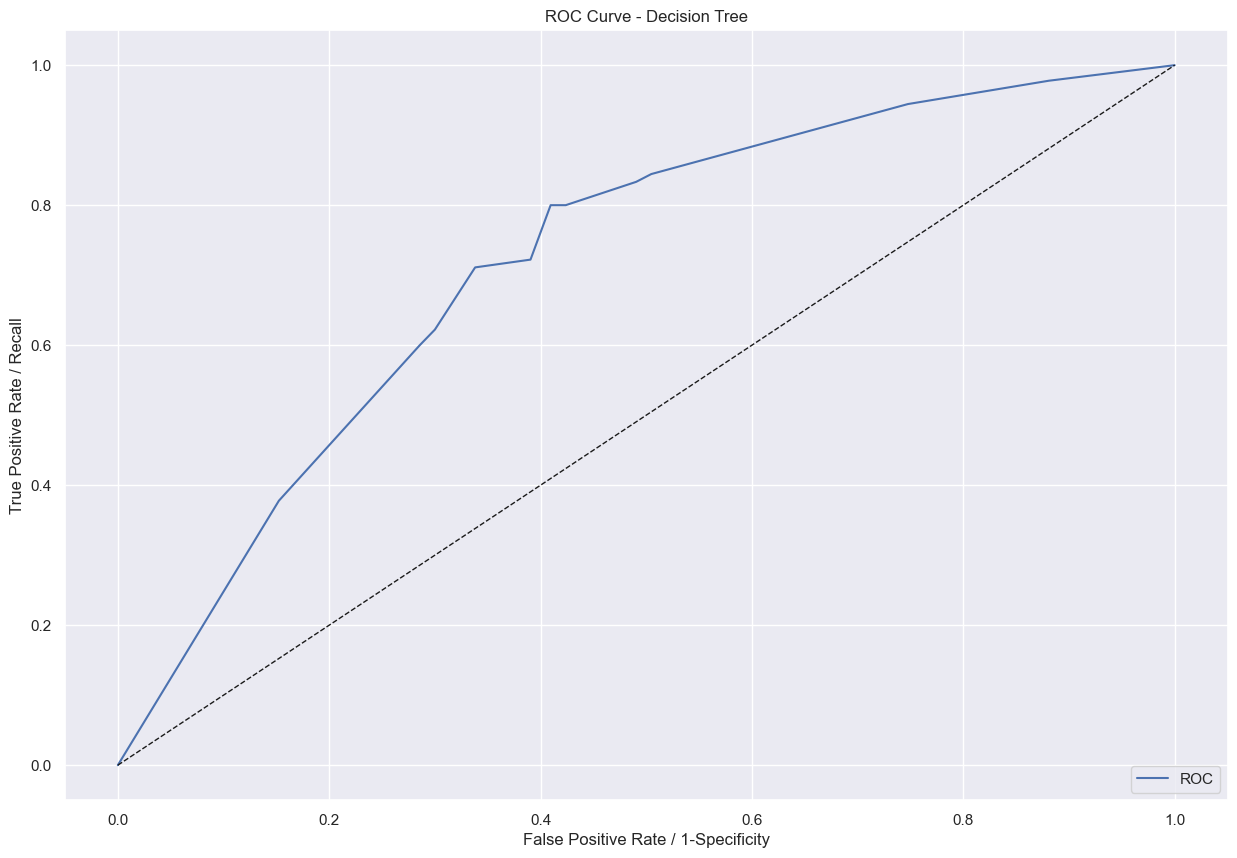

The AUC Score for the train is: 0.7246793002915451
The AUC Score for the test is: 0.7210846560846561


In [66]:
plt.figure(figsize=(15, 10))

probs = pipeline2.predict_proba(X_test)

FP,TP,thresholds = metrics.roc_curve(y_test,probs[:,1])

plt.plot(FP,TP,label="ROC")

plt.plot([0, 1], [0, 1], '--k', lw=1)

plt.title("ROC Curve - Decision Tree")

plt.xlabel("False Positive Rate / 1-Specificity")

plt.ylabel("True Positive Rate / Recall")

plt.legend(loc = "lower right")

plt.show()

print("The AUC Score for the train is:", roc_auc_score(y_train, pipeline2.predict_proba(X_train)[:,1]))

print("The AUC Score for the test is:", roc_auc_score(y_test, pipeline2.predict_proba(X_test)[:,1]))

### **Learning Curve**

Learning cures are widely used diagnostic tool for machine learning problems since it shows the score evolution throughout different subsets of data

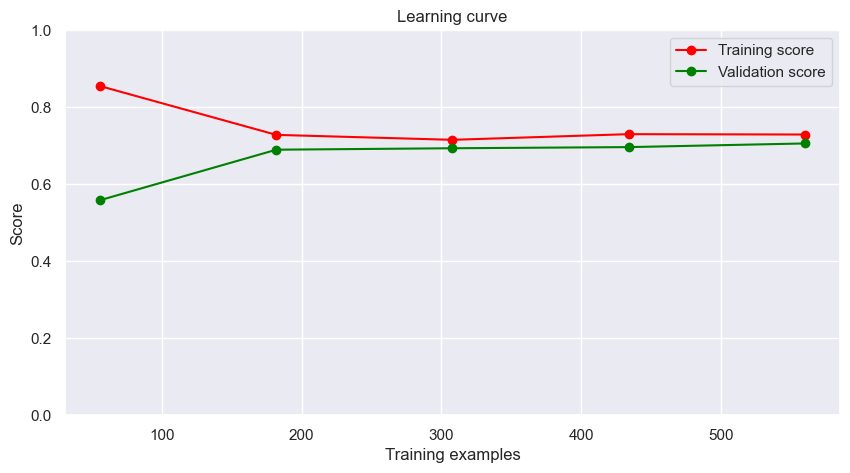

In [67]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure(figsize=(10, 5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    array = np.linspace(1, int(X.shape[0]*0.8))
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = "roc_auc")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='red',
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='green',
             label='Validation score')

    plt.legend(loc = 'best')
    return plt


g = plot_learning_curve(clf, "Learning curve", X_train, y_train, cv=KF,ylim=(0, 1), n_jobs = -1,
                  train_sizes=np.linspace(0.1, 1.0, 5))

As we can see by the plot as training instances increase the model is able to generalize the data well. This is easily by the distance between both curves.

### End!